<a href="https://colab.research.google.com/github/E-Fung/Classification_PCD/blob/E-Fung-patch-1/PCD_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIALIZE LIBRARIES AND FINAL FILE NAMES**

In [1]:
#########################################################################################################################################################################
#   Initialize libraries and such
#########################################################################################################################################################################

%tensorflow_version 2.x  # this line is not required unless you are in a notebook
from __future__ import absolute_import, division, print_function, unicode_literals
from mpl_toolkits.mplot3d import Axes3D
from google.colab import files
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
import os
import math

# Print versions
!python --versions
print('Numpy ' + np.__version__)
print('TensorFlow ' + tf.__version__)
print('Keras ' + tf.keras.__version__)

tflite_model_name = 'PCD_Model'
c_model_name = 'PCD_Model'

class AdditionalValidationSets(tf.keras.callbacks.Callback):
    def __init__(self, validation_sets, verbose=0, batch_size=None):
        """
        :param validation_sets:
        a list of 3-tuples (validation_data, validation_targets, validation_set_name)
        or 4-tuples (validation_data, validation_targets, sample_weights, validation_set_name)
        :param verbose:
        verbosity mode, 1 or 0
        :param batch_size:
        batch size to be used when evaluating on the additional datasets
        """
        super(AdditionalValidationSets, self).__init__()
        self.validation_sets = validation_sets
        for validation_set in self.validation_sets:
            if len(validation_set) not in [3, 4]:
                raise ValueError()
        self.epoch = []
        self.history = {}
        self.verbose = verbose
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        # record the same values as History() as well
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        # evaluate on the additional validation sets
        for validation_set in self.validation_sets:
            if len(validation_set) == 3:
                validation_data, validation_targets, validation_set_name = validation_set
                sample_weights = None
            elif len(validation_set) == 4:
                validation_data, validation_targets, sample_weights, validation_set_name = validation_set
            else:
                raise ValueError()

            results = self.model.evaluate(x=validation_data,
                                          y=validation_targets,
                                          verbose=self.verbose,
                                          sample_weight=sample_weights,
                                          batch_size=self.batch_size)

            for metric, result in zip(self.model.metrics_names,results):
                valuename = validation_set_name + '_' + metric
                self.history.setdefault(valuename, []).append(result)

#########################################################################################################################################################################

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
unknown option --versions
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.
Numpy 1.19.5
TensorFlow 2.4.1
Keras 2.4.0


# **UPLOADING**

In [97]:
#########################################################################################################################################################################
#   Uploading Files
#########################################################################################################################################################################

file_name = 'data_n05' #Change this to the name of the csv file you are uploading
uploaded = files.upload()
pd.read_csv(io.StringIO(uploaded[file_name+'.csv'].decode('utf-8')))

#########################################################################################################################################################################

Saving data_n01.csv to data_n01.csv


KeyError: ignored

# **PROCESSING**

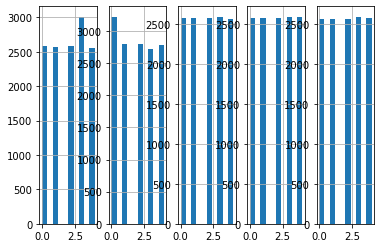

In [99]:
dd1 = 'data_n01'
dd2 = 'data_n02'
dd3 = 'data_n03'
dd4 = 'data_n04'
dd5 = 'data_n05'
imp_dd1 = pd.read_csv(dd1+'.csv')
imp_dd2 = pd.read_csv(dd2+'.csv')
imp_dd3 = pd.read_csv(dd3+'.csv')
imp_dd4 = pd.read_csv(dd4+'.csv')
imp_dd5 = pd.read_csv(dd5+'.csv')
plt.subplot(1,5,1)
imp_dd1.Class.hist()
plt.subplot(1,5,2)
imp_dd2.Class.hist()
plt.subplot(1,5,3)
imp_dd3.Class.hist()
plt.subplot(1,5,4)
imp_dd4.Class.hist()
plt.subplot(1,5,5)
imp_dd5.Class.hist()

In [127]:
#########################################################################################################################################################################
#   This block of code is for processing the data
#########################################################################################################################################################################

def get_data(i):

  #Change these
  train_row_increments = 5
  test_row_increments = 5

  data_arr = ['data_n01','data_n02','data_n03','data_n04','data_n05']
  test_data = data_arr[i]
  data_arr.remove(data_arr[i])

  train_data_01 = data_arr[0]
  train_data_02 = data_arr[1]
  train_data_03 = data_arr[2]
  train_data_04 = data_arr[3]

  #Initialize dataframes for storing the data and combine them to increase effectiveness of model
  train_data1 = pd.read_csv(train_data_01+'.csv')
  train_data2 = pd.read_csv(train_data_02+'.csv')
  train_data3 = pd.read_csv(train_data_03+'.csv')
  train_data4 = pd.read_csv(train_data_04+'.csv')
  train_data_combined = pd.concat([train_data1,train_data2,train_data3,train_data4],ignore_index=True)

  #Process the data::
  train_data_sampled = train_data_combined[1::train_row_increments]
  # train_data_sampled = train_data_combined[1::train_row_increments]#sample every 'train_row_increments' row (IMUs give data very frequently so the data is very similar)
  data_shuffled = train_data_sampled.sample(frac=1).reset_index(drop=True)#shuffle it
  d0 = data_shuffled.loc[data_shuffled['Class'] == 0]#how much data for each posture
  d1 = data_shuffled.loc[data_shuffled['Class'] == 1]
  d2 = data_shuffled.loc[data_shuffled['Class'] == 2]
  d3 = data_shuffled.loc[data_shuffled['Class'] == 3]
  d4 = data_shuffled.loc[data_shuffled['Class'] == 4]
  min_class = min(len(d0),len(d1),len(d2),len(d3),len(d4))
  d0_split = d0.sample(frac=(min_class/len(d0)),random_state=1) #get the same amount for each posture
  d1_split = d1.sample(frac=(min_class/len(d1)),random_state=1) 
  d2_split = d2.sample(frac=(min_class/len(d2)),random_state=1) 
  d3_split = d3.sample(frac=(min_class/len(d3)),random_state=1) 
  d4_split = d4.sample(frac=(min_class/len(d4)),random_state=1) 
  data_final_combine = pd.concat([d0_split,d1_split,d2_split,d3_split,d4_split],ignore_index=True)#combine
  data_processed = data_final_combine.sample(frac=1).reset_index(drop=True)#shuffle again
  posture_processed = data_processed.pop('Class')
  data_processed = data_processed/180

  global x_val,x_train,y_val,y_train,test,test_pop

  #Split the data into 3 sets:: Training, Validation(used to check against overfitting, you dont want training accuracy to be over validation) 
  val_ratio = 0.3    # Percentage of samples that should be held for validation set
  length_data_processed = data_processed.shape[0]
  val_split = int(val_ratio * length_data_processed)
  x_val, x_train = np.split(data_processed, [val_split])
  y_val, y_train = np.split(posture_processed, [val_split])
  assert(x_train.size + x_val.size) == data_processed.size
  # plt.subplot(1,2,1)
  # y_train.hist() #displays the histogram based on posture
  # plt.title("Training")
  # plt.xlabel('postures')

  #Process the data for the testing data (This will be data from a new user that has never had their data in the training set)
  test = pd.read_csv(test_data+'.csv')
  test = test [1::test_row_increments]
  test = test.sample(frac=1).reset_index(drop=True)
  test_pop = test.pop('Class')
  test = test / 180
  # plt.subplot(1,2,2)
  # test_pop.hist()
  # plt.title("Test")
  # plt.xlabel('postures')

#########################################################################################################################################################################

# **TRAINING**

Model: "sequential_357"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_357 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_714 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_715 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

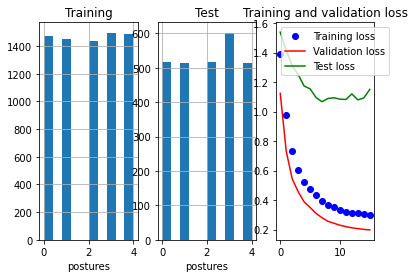

84/84 - 0s - loss: 1.1507 - accuracy: 0.6679

Test accuracy: 0.6679174304008484


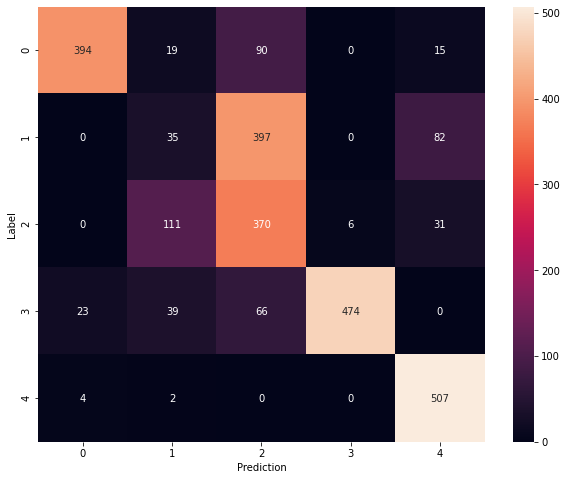

Model: "sequential_358"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_358 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_716 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_717 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

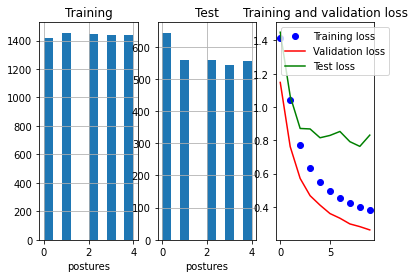

90/90 - 0s - loss: 0.8308 - accuracy: 0.7053

Test accuracy: 0.7053477764129639


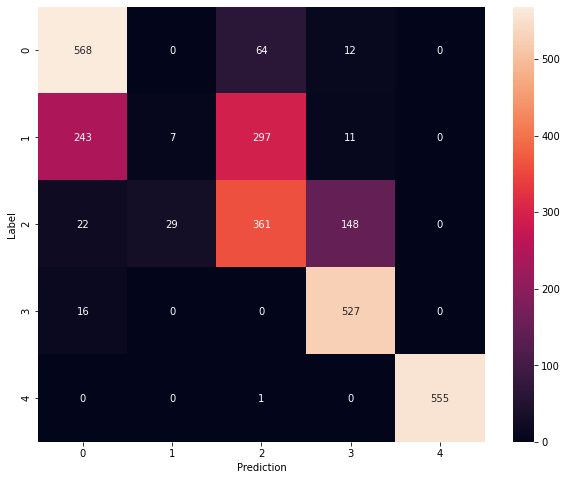

Model: "sequential_359"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_359 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_718 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_719 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

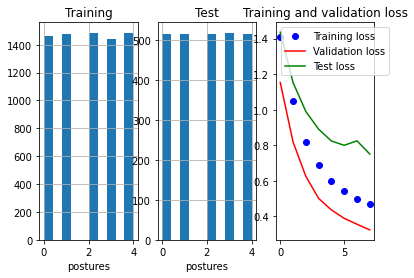

81/81 - 0s - loss: 0.7505 - accuracy: 0.6826

Test accuracy: 0.6825766563415527


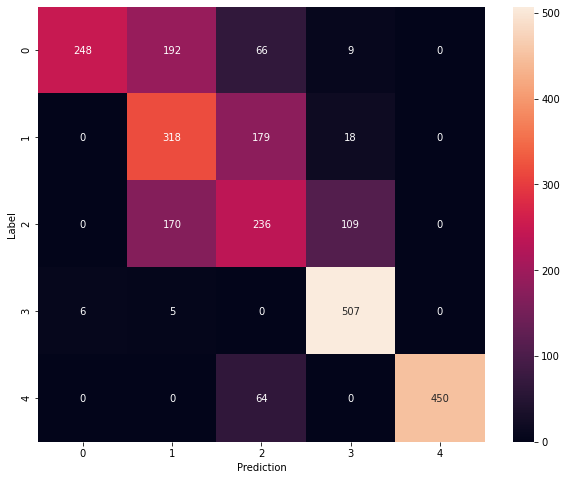

Model: "sequential_360"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_360 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_720 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_721 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

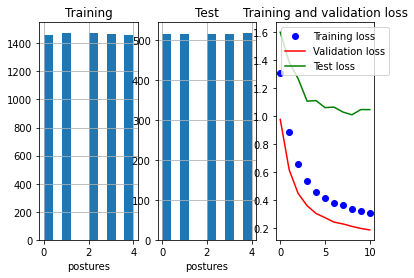

81/81 - 0s - loss: 1.0443 - accuracy: 0.5985

Test accuracy: 0.5985260009765625


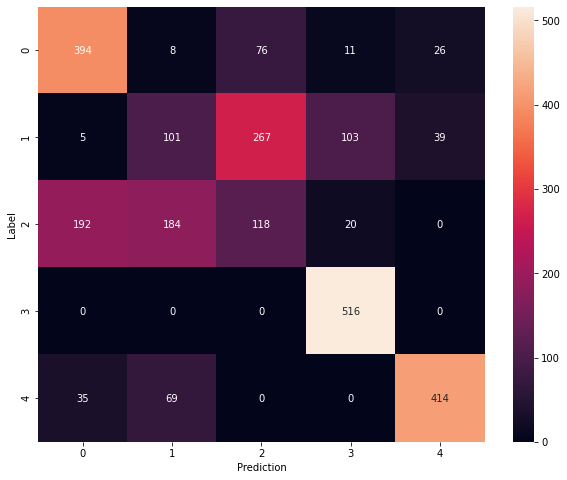

Model: "sequential_361"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_361 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_722 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_723 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

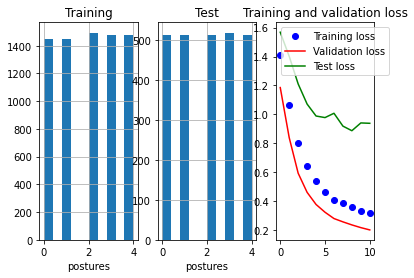

81/81 - 0s - loss: 0.9386 - accuracy: 0.6912

Test accuracy: 0.6911707520484924


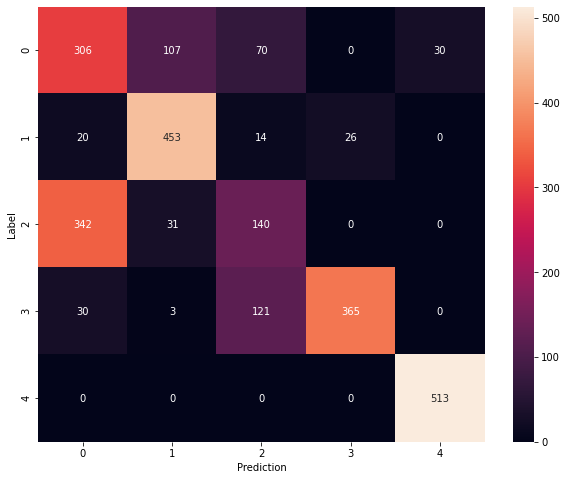

Model: "sequential_362"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_362 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_724 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_725 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

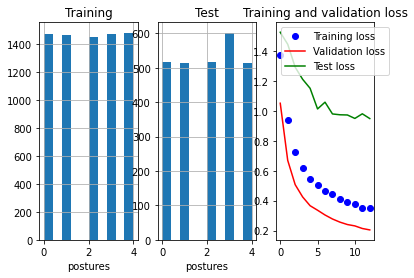

84/84 - 0s - loss: 0.9476 - accuracy: 0.6161

Test accuracy: 0.6161350607872009


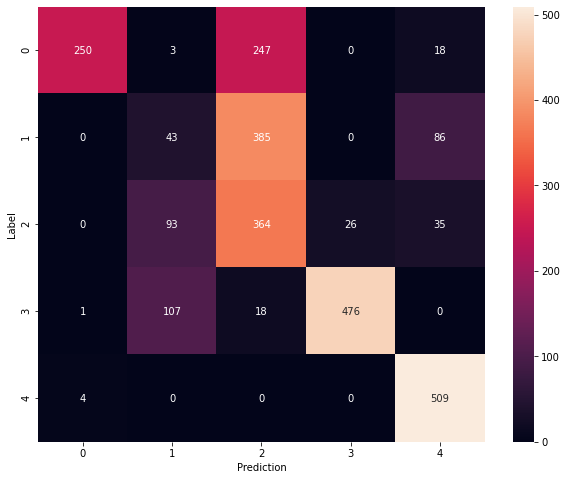

Model: "sequential_363"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_363 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_726 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_727 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

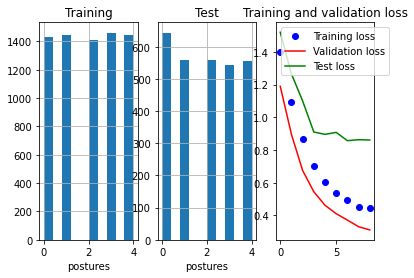

90/90 - 0s - loss: 0.8608 - accuracy: 0.6449

Test accuracy: 0.6448794007301331


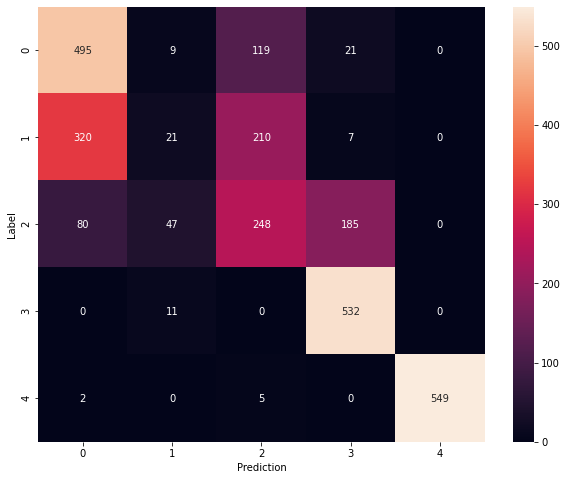

Model: "sequential_364"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_364 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_728 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_729 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

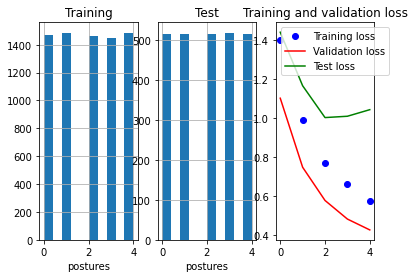

81/81 - 0s - loss: 1.0436 - accuracy: 0.5778

Test accuracy: 0.5778036713600159


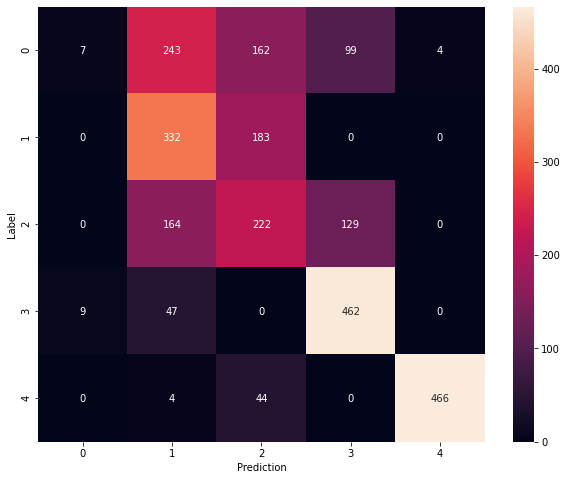

Model: "sequential_365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_365 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_730 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_731 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

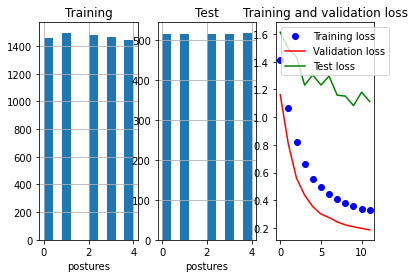

81/81 - 0s - loss: 1.1121 - accuracy: 0.5842

Test accuracy: 0.5841737985610962


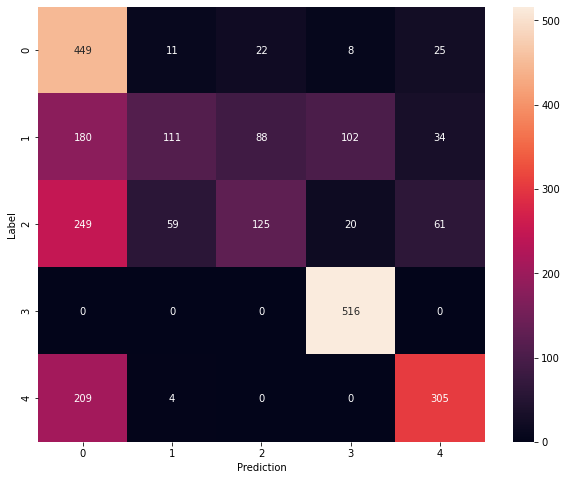

Model: "sequential_366"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_366 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_732 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_733 (Dropout)        (None, 15)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 80        
Total params: 935
Trainable params: 935
Non-trainable params: 0
______________________________________________________

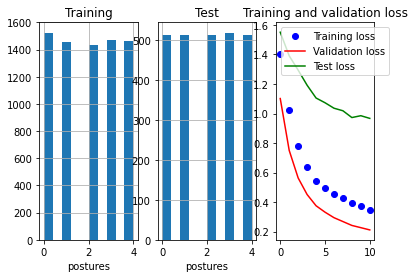

81/81 - 0s - loss: 0.9673 - accuracy: 0.6597

Test accuracy: 0.6596655249595642


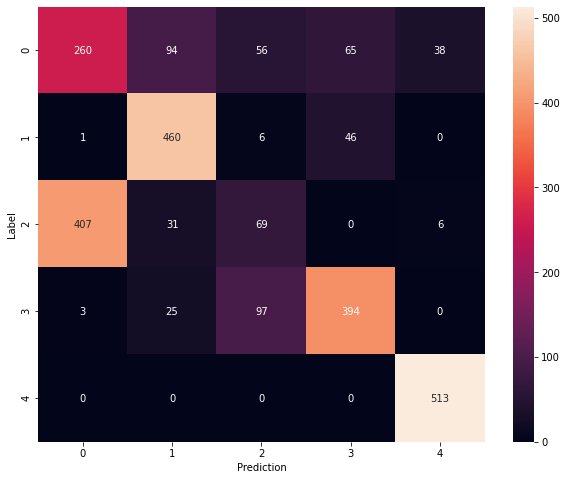

Model: "sequential_367"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_367 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_734 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_735 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

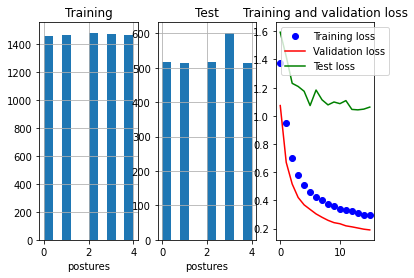

84/84 - 0s - loss: 1.0623 - accuracy: 0.6266

Test accuracy: 0.6266416311264038


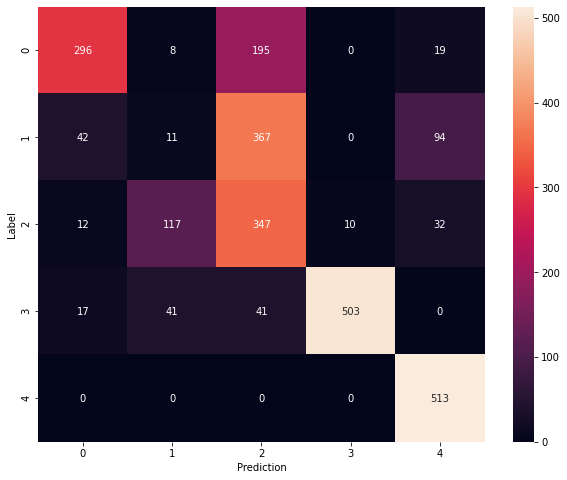

Model: "sequential_368"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_368 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_736 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_737 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

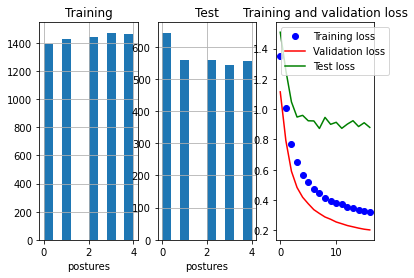

90/90 - 0s - loss: 0.8796 - accuracy: 0.7274

Test accuracy: 0.7273680567741394


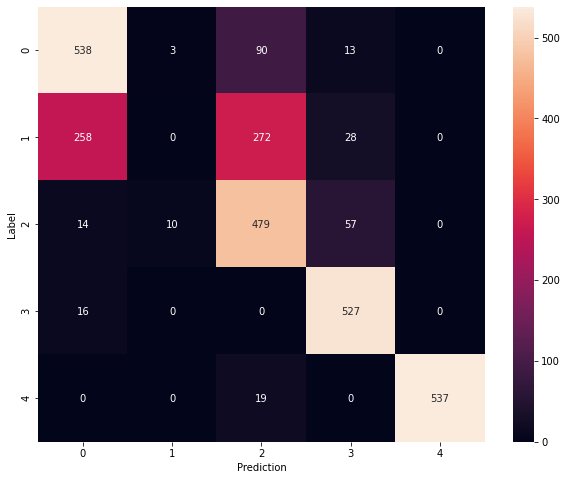

Model: "sequential_369"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_369 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_738 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_739 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

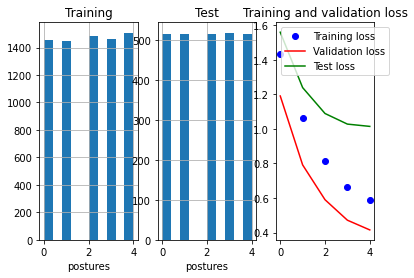

81/81 - 0s - loss: 1.0147 - accuracy: 0.6100

Test accuracy: 0.610011637210846


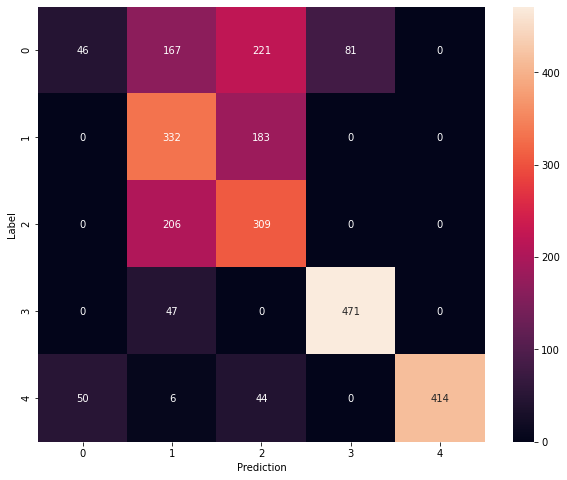

Model: "sequential_370"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_370 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_740 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_741 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

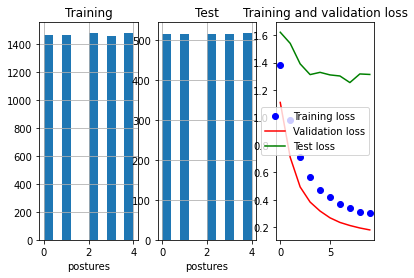

81/81 - 0s - loss: 1.3139 - accuracy: 0.5140

Test accuracy: 0.5139642953872681


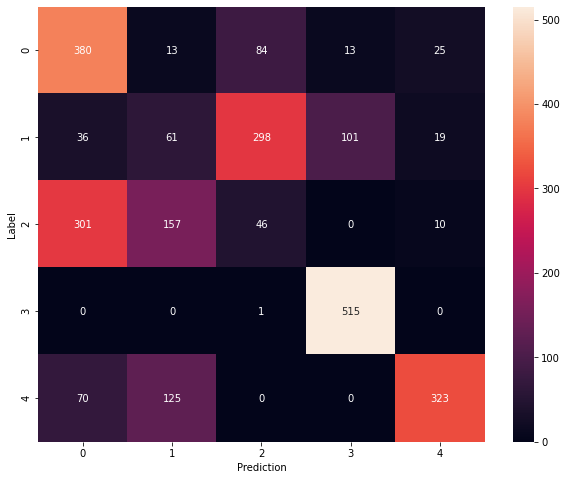

Model: "sequential_371"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_371 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_742 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_743 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

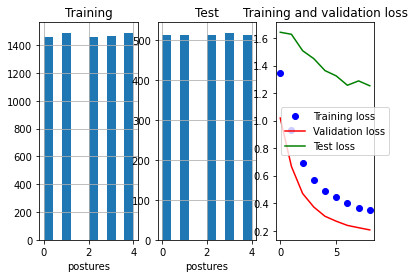

81/81 - 0s - loss: 1.2532 - accuracy: 0.5298

Test accuracy: 0.5297549366950989


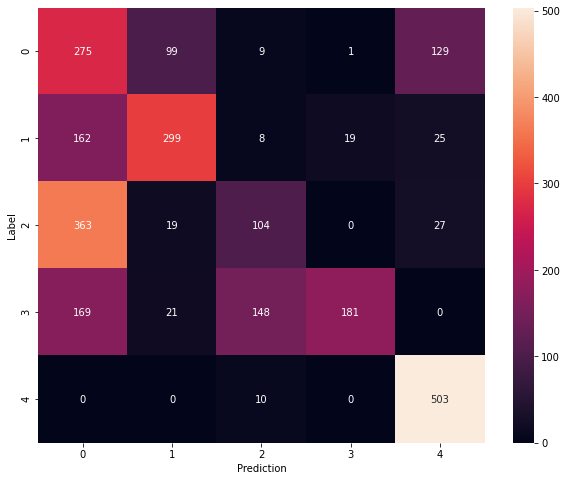

Model: "sequential_372"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_372 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_744 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_745 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

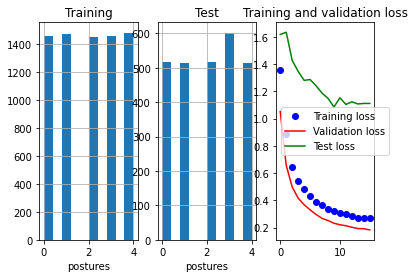

84/84 - 0s - loss: 1.1109 - accuracy: 0.6345

Test accuracy: 0.6345216035842896


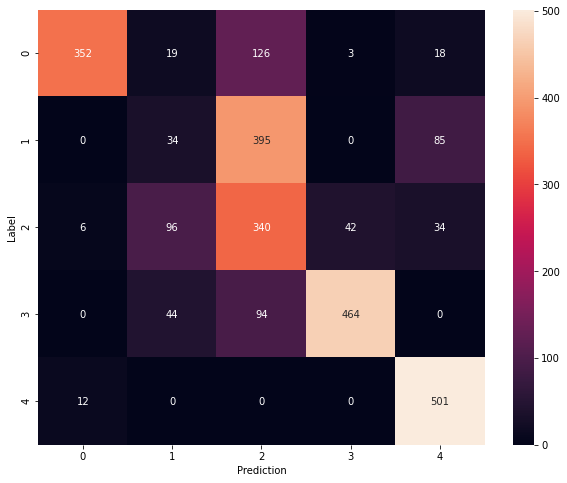

Model: "sequential_373"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_373 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_746 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_747 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

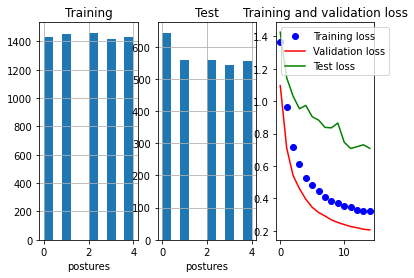

90/90 - 0s - loss: 0.7091 - accuracy: 0.7029

Test accuracy: 0.7029010653495789


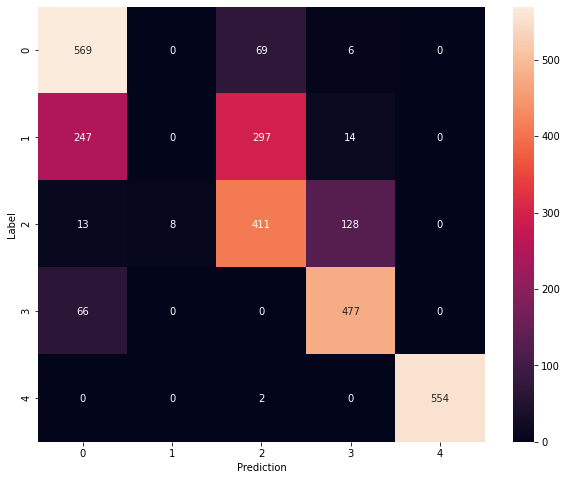

Model: "sequential_374"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_374 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_748 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_749 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

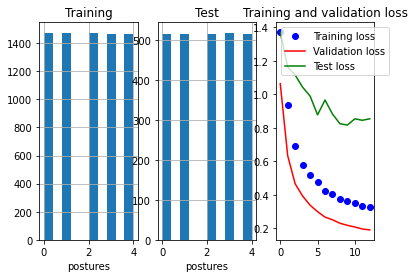

81/81 - 0s - loss: 0.8538 - accuracy: 0.7148

Test accuracy: 0.7147846221923828


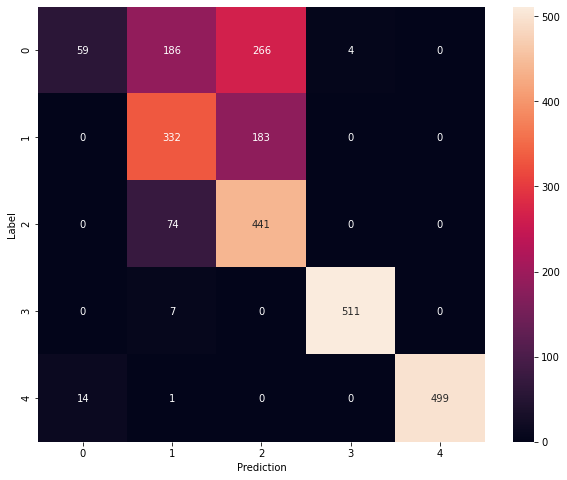

Model: "sequential_375"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_375 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_750 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_751 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

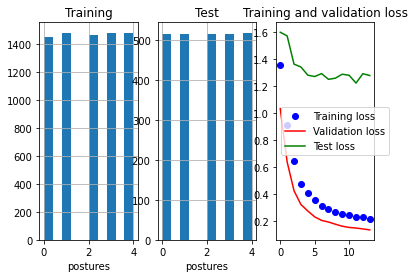

81/81 - 0s - loss: 1.2779 - accuracy: 0.5706

Test accuracy: 0.5705973505973816


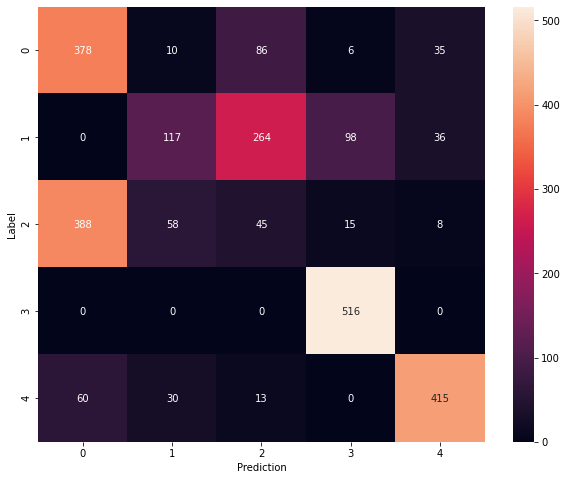

Model: "sequential_376"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_376 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_752 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dropout_753 (Dropout)        (None, 20)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 105       
Total params: 1,115
Trainable params: 1,115
Non-trainable params: 0
__________________________________________________

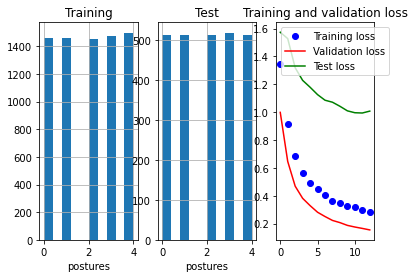

81/81 - 0s - loss: 1.0071 - accuracy: 0.6383

Test accuracy: 0.6382730603218079


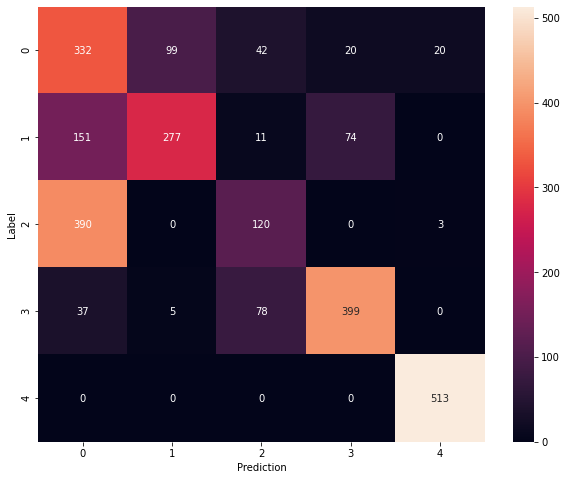

Model: "sequential_377"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_377 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_754 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_755 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

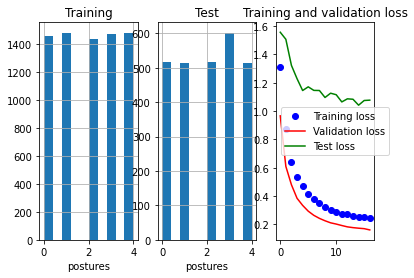

84/84 - 0s - loss: 1.0773 - accuracy: 0.6754

Test accuracy: 0.6754221320152283


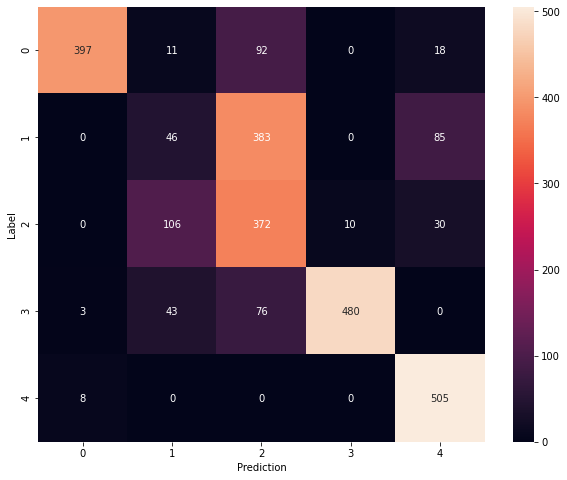

Model: "sequential_378"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_378 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_756 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_757 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

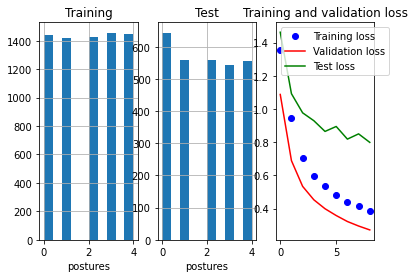

90/90 - 0s - loss: 0.7988 - accuracy: 0.6508

Test accuracy: 0.6508213877677917


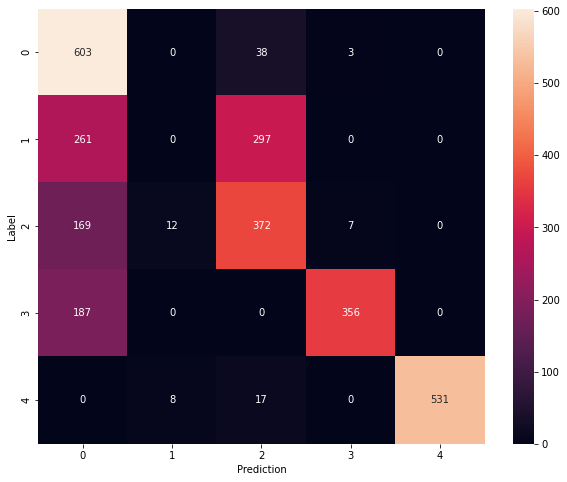

Model: "sequential_379"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_379 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_758 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_759 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

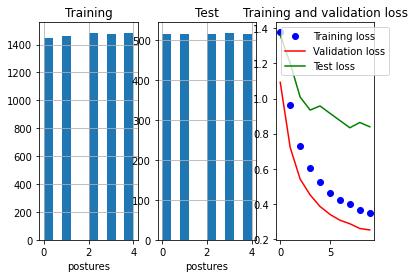

81/81 - 0s - loss: 0.8388 - accuracy: 0.7202

Test accuracy: 0.7202172875404358


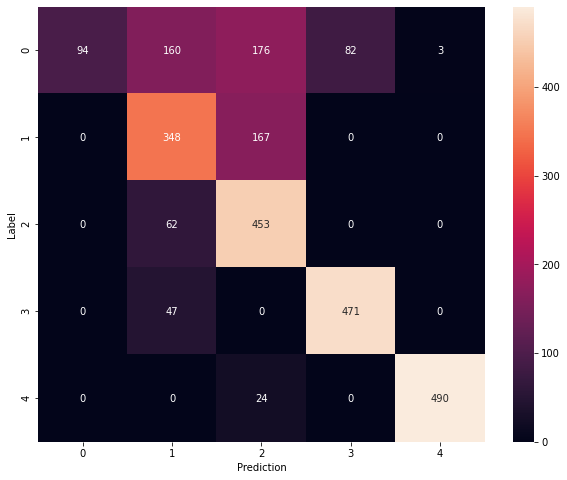

Model: "sequential_380"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_380 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_760 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_761 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

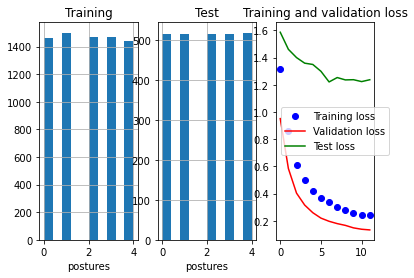

81/81 - 0s - loss: 1.2371 - accuracy: 0.5787

Test accuracy: 0.5787432193756104


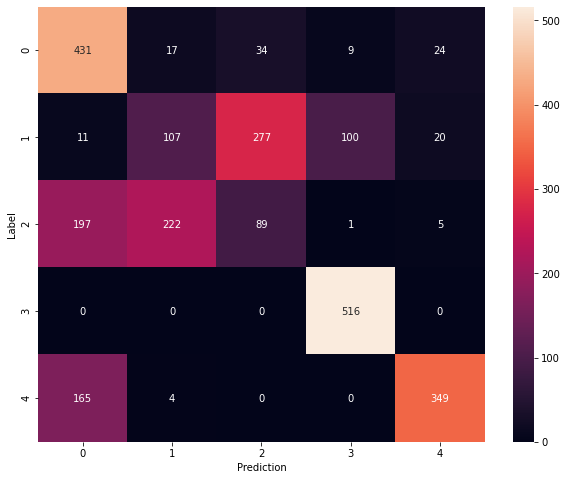

Model: "sequential_381"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_381 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_762 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_763 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

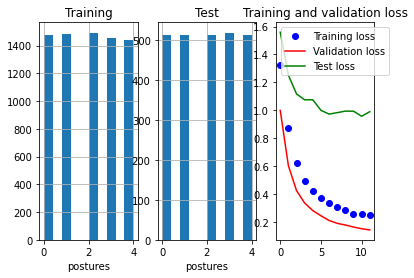

81/81 - 0s - loss: 0.9890 - accuracy: 0.6511

Test accuracy: 0.6511085033416748


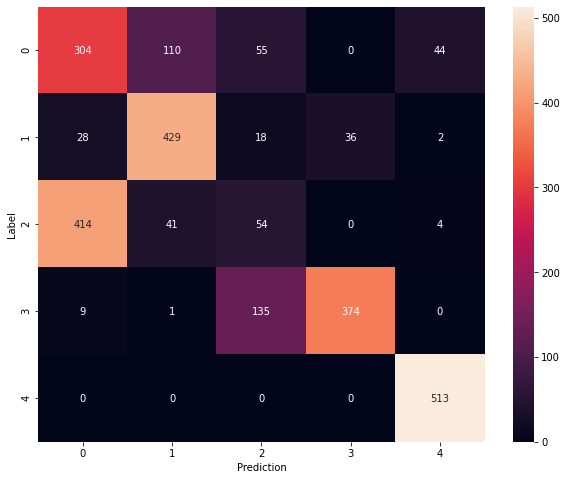

Model: "sequential_382"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_382 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_764 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_765 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

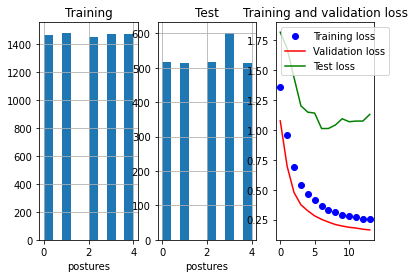

84/84 - 0s - loss: 1.1285 - accuracy: 0.6405

Test accuracy: 0.6405253410339355


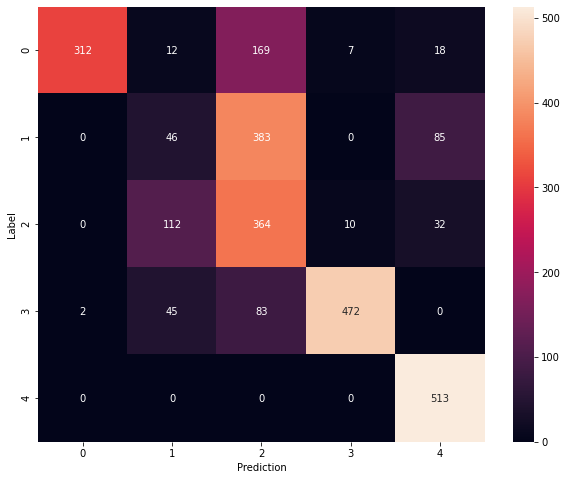

Model: "sequential_383"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_383 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_766 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_767 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

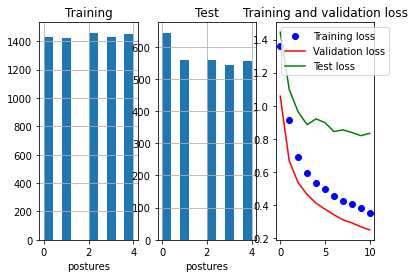

90/90 - 0s - loss: 0.8327 - accuracy: 0.6963

Test accuracy: 0.6962600350379944


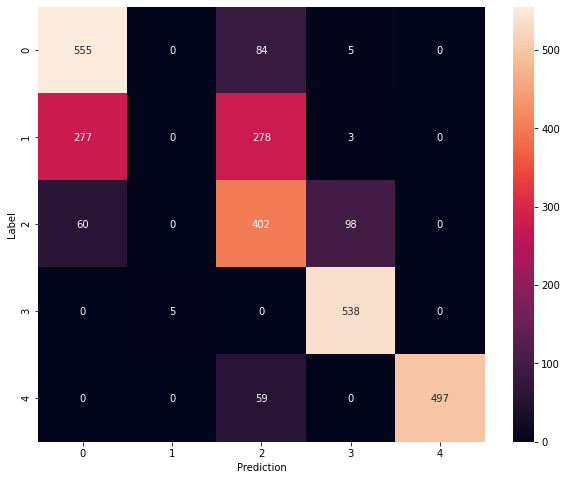

Model: "sequential_384"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_384 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_768 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_769 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

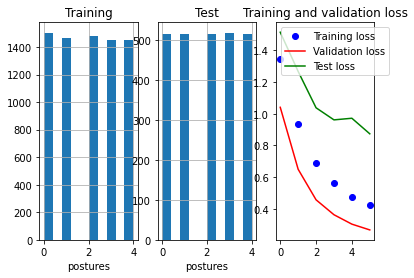

81/81 - 0s - loss: 0.8734 - accuracy: 0.6442

Test accuracy: 0.6441598534584045


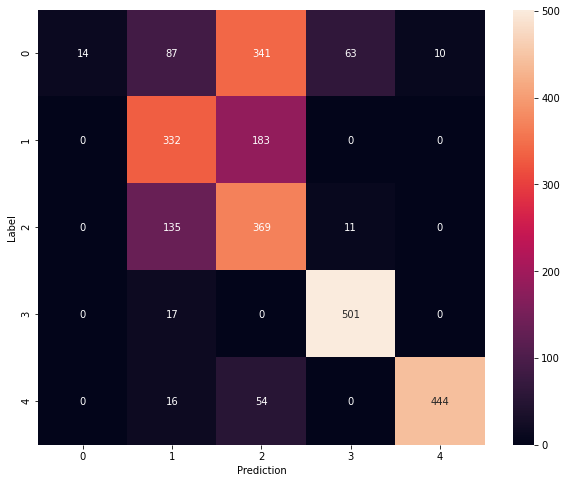

Model: "sequential_385"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_385 (Flatten)        (None, 12)                0         
_________________________________________________________________
Layer_1 (Dense)              (None, 30)                390       
_________________________________________________________________
dropout_770 (Dropout)        (None, 30)                0         
_________________________________________________________________
Layer_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dropout_771 (Dropout)        (None, 25)                0         
_________________________________________________________________
Predicted_Posture (Dense)    (None, 5)                 130       
Total params: 1,295
Trainable params: 1,295
Non-trainable params: 0
__________________________________________________

In [ ]:
#########################################################################################################################################################################
#   This block of code is for trying different model configurations and seeing what works best
#########################################################################################################################################################################

#Affects the range of layers that the models will have and how much times we want to test that setup
i_range = 10
j_range = 3
k_range = 10

hidden_layer_1 = 30
hidden_layer_2 = 15
hidden_layer_1_interval = 5
hidden_layer_2_interval = 5

starting_num_epochs = 30

dropout_percent = 0.1
callback_patience=2
decay_rate = 0.90
decay_steps = 200

saved_metric_name = 'Model_CONFIG'
#########################################################################################################################################################################

curr_run = 0
total_run = i_range*j_range*k_range 

#Test different configuration of models
test_history = pd.DataFrame(columns=['Accuracy','Layer 1','Layer 2','Dropout %','Average of','Patience','IN Learning Rate','decay_rate','decay_steps'])
for i in range(0,i_range):
  for j in range(0,j_range):
    average_accuracy = 0;
    for k in range(0,k_range):
      
      get_data(curr_run%5)
      plt.subplot(1,3,1)
      y_train.hist() #displays the histogram based on posture
      plt.title("Training")
      plt.xlabel('postures')
      plt.subplot(1,3,2)
      test_pop.hist()
      plt.title("Test")
      plt.xlabel('postures')

      initial_learning_rate = (hidden_layer_1+i*hidden_layer_1_interval)/10000
      #Creates the model structure and chooses the activation function for each layer
      model = tf.keras.Sequential([                      
          tf.keras.layers.Flatten(input_shape=(12,1)),
          tf.keras.layers.Dense(hidden_layer_1+i*hidden_layer_1_interval, activation='relu', name= "Layer_1"),  #hidden layers are generally: relu, sigmoid, tanh (Usually constant for all hidden layers)
          tf.keras.layers.Dropout(dropout_percent), #dropouts only occur during training
          tf.keras.layers.Dense(hidden_layer_2+j*hidden_layer_2_interval, activation='relu', name= "Layer_2"),  
          tf.keras.layers.Dropout(dropout_percent),
          tf.keras.layers.Dense(5, activation='linear', name= "Predicted_Posture"), #output layers are generally: linear, sigmoid, softmax
      ])
      model.summary()

      #Stops the model training early to prevent overfitting
      callbacks = [
      tf.keras.callbacks.EarlyStopping(# Stop training when `val_loss` is no longer improving
          monitor="val_accuracy",
          # min_delta=callback_delta,
          mode='auto',
          patience=callback_patience,# "no longer improving" being further defined as "for at least x epochs"
          verbose=1,
        )
      ] 

      #Addes the x_val dataset to be tested 
      val_test = AdditionalValidationSets([(x_val, y_val, 'val2')])

      #Saves the models when the accuracy is highest based on the test values
      checkpoint_path = "training_"+str(curr_run)+"/cp.ckpt"
      checkpoint_dir = os.path.dirname(checkpoint_path)
      cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor="val_accuracy",mode= "auto",save_best_only=True,save_weights_only=True,verbose=1)

      #Assign type of: optimizer, loss, and metric
      lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True)
      opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
      model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])

      #Print out which loop we are undergoing
      print(str(curr_run)+" out of "+str(total_run) + " runs")

      #Train the model with the training data and save the stats in history
      history = model.fit(x_train,y_train,epochs=starting_num_epochs,callbacks = [val_test,callbacks,cp_callback],validation_data=(test, test_pop))

      #Plots the training vs validation loss
      loss = history.history['loss']
      test_loss = history.history['val_loss']
      val_loss = val_test.history['val2_loss']
      epochs = history.epoch
      plt.subplot(1,3,3)
      plt.plot(epochs, loss, 'bo', label='Training loss')
      plt.plot(epochs, val_loss, 'r', label='Validation loss')
      plt.plot(epochs, test_loss, 'g', label='Test loss')
      plt.title('Training and validation loss')
      plt.legend()
      plt.show()

      #Test the model with unseen data from the original training dataset that was split
      # x_test_loss, x_test_acc = model.evaluate(x_test,  y_test, verbose=2)
      # print('\nX_Test accuracy:', x_test_acc)

      #Test the model with unseen data and record the settings
      test_loss, test_acc = model.evaluate(test,  test_pop, verbose=2)
      print('\nTest accuracy:', test_acc)

      #create a confusion matrix to see model performance
      predictions = model.predict(test)
      predictions = np.argmax(predictions,axis = 1)
      confusion_mtx = tf.math.confusion_matrix(
          test_pop, predictions, 5, weights=None, dtype=tf.dtypes.int32,
          name='PCD_Confusion_Matrix'
      )
      plt.figure(figsize=(10, 8))
      sns.heatmap(confusion_mtx,annot=True, fmt='g')
      plt.xlabel('Prediction')
      plt.ylabel('Label')
      plt.show()
      average_accuracy = average_accuracy + test_acc
      curr_run = curr_run + 1

    #Records the test results for specific model configuration
    average_accuracy = average_accuracy/k_range
    new_row = {'Accuracy':average_accuracy,'Layer 1':hidden_layer_1+i*hidden_layer_1_interval,'Layer 2':hidden_layer_2+j*hidden_layer_2_interval,'Dropout %':dropout_percent,
               'Average of':k_range,'Patience':callback_patience,'IN Learning Rate':initial_learning_rate,'decay_rate':decay_rate,'decay_steps':decay_steps}
    test_history = test_history.append(new_row, ignore_index=True)
test_history.to_csv(saved_metric_name+".csv",index=False)
from google.colab import files
files.download(saved_metric_name+".csv")
#########################################################################################################################################################################

In [132]:
# Loads the weights
model.load_weights("training_1/cp.ckpt")

# Re-evaluate the model
loss, acc = model.evaluate(test, test_pop, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

90/90 - 0s - loss: 1.0651 - accuracy: 0.5883
Restored model, accuracy: 58.83%


In [140]:
 test_history

,Accuracy,Layer 1,Layer 2,Dropout %,Average of,Patience,IN Learning Rate,decay_rate,decay_steps
0,0.383865,30.0,15.0,0.1,1.0,2.0,0.003,0.9,200.0
1,0.569381,30.0,20.0,0.1,1.0,2.0,0.003,0.9,200.0


In [ ]:
predictions = model.predict(test)
predictions = np.argmax(predictions)
predictions


In [76]:
from google.colab import files
test_history.to_csv('Dropout_01_5.csv',index=False)
files.download("Dropout_01_5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **CONVERT**

In [99]:
#########################################################################################################################################################################
#   Optimize the model for size and convert to tflite model
#########################################################################################################################################################################

#Covert the model to a tflite model & optimize to reduce the size
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()
open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

#########################################################################################################################################################################

INFO:tensorflow:Assets written to: /tmp/tmp7zmu5mu3/assets


7792

In [100]:
#########################################################################################################################################################################
#   Function to convert tflite file to C header file
#########################################################################################################################################################################

# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

#########################################################################################################################################################################

In [101]:
#########################################################################################################################################################################
#   Convert to c-header file via function
#########################################################################################################################################################################

# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, c_model_name))

#########################################################################################################################################################################